# FloPy

### MT3D-USGS Example

Demonstrates functionality of the flopy MT3D-USGS module using the 'Crank-Nicolson' example distributed with MT3D-USGS.  

#### Problem description:

* Grid dimensions: 1 Layer, 3 Rows, 650 Columns
* Stress periods: 3
* Units are in seconds and meters
* Flow package: UPW
* Stress packages: SFR, GHB
* Solvers: NWT, GCG

In [1]:
import sys
import os
import platform
import string
from io import StringIO, BytesIO
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]
numpy version: 1.19.2
matplotlib version: 3.4.2
flopy version: 3.3.5


In [2]:
modelpth = os.path.join("data")
modelname = "CrnkNic"
mfexe = "mfnwt"
mtexe = "mt3dusgs"
if platform.system() == "Windows":
    mfexe += ".exe"
    mtexe += ".exe"

# Make sure modelpth directory exists
if not os.path.isdir(modelpth):
    os.makedirs(modelpth, exist_ok=True)

# Instantiate MODFLOW object in flopy
mf = flopy.modflow.Modflow(
    modelname=modelname, exe_name=mfexe, model_ws=modelpth, version="mfnwt"
)

Set up model discretization

In [3]:
Lx = 650.0
Ly = 15
nrow = 3
ncol = 650
nlay = 1

delr = Lx / ncol
delc = Ly / nrow

xmax = ncol * delr
ymax = nrow * delc

X, Y = np.meshgrid(
    np.linspace(delr / 2, xmax - delr / 2, ncol),
    np.linspace(ymax - delc / 2, 0 + delc / 2, nrow),
)

Instantiate output control (oc) package for MODFLOW-NWT

In [4]:
# Output Control: Create a flopy output control object
oc = flopy.modflow.ModflowOc(mf)

Instantiate solver package for MODFLOW-NWT

In [5]:
# Newton-Raphson Solver: Create a flopy nwt package object

headtol = 1.0e-4
fluxtol = 5
maxiterout = 5000
thickfact = 1e-06
linmeth = 2
iprnwt = 1
ibotav = 1

nwt = flopy.modflow.ModflowNwt(
    mf,
    headtol=headtol,
    fluxtol=fluxtol,
    maxiterout=maxiterout,
    thickfact=thickfact,
    linmeth=linmeth,
    iprnwt=iprnwt,
    ibotav=ibotav,
    options="SIMPLE",
)

Instantiate discretization (DIS) package for MODFLOW-NWT

In [6]:
# The equations for calculating the ground elevation in the 1 Layer CrnkNic model.
# Although Y isn't used, keeping it here for symetry


def topElev(X, Y):
    return 100.0 - (np.ceil(X) - 1) * 0.03


grndElev = topElev(X, Y)
bedRockElev = grndElev - 3.0

Steady = [False, False, False]
nstp = [1, 1, 1]
tsmult = [1.0, 1.0, 1.0]

# Stress periods extend from (12AM-8:29:59AM); (8:30AM-11:30:59AM); (11:31AM-23:59:59PM)
perlen = [30600, 10800, 45000]

# Create the discretization object
# itmuni = 1 (seconds); lenuni = 2 (meters)
dis = flopy.modflow.ModflowDis(
    mf,
    nlay,
    nrow,
    ncol,
    nper=3,
    delr=delr,
    delc=delc,
    top=grndElev,
    botm=bedRockElev,
    laycbd=0,
    itmuni=1,
    lenuni=2,
    steady=Steady,
    nstp=nstp,
    tsmult=tsmult,
    perlen=perlen,
)

Instantiate upstream weighting (UPW) flow package for MODFLOW-NWT

In [7]:
# UPW parameters
# UPW must be instantiated after DIS.  Otherwise, during the mf.write_input() procedures,
# flopy will crash.


laytyp = 1
layavg = 2
chani = 1.0
layvka = 1
iphdry = 0
hk = 0.1
hani = 1
vka = 1.0
ss = 0.000001
sy = 0.20
hdry = -888

upw = flopy.modflow.ModflowUpw(
    mf,
    laytyp=laytyp,
    layavg=layavg,
    chani=chani,
    layvka=layvka,
    ipakcb=53,
    hdry=hdry,
    iphdry=iphdry,
    hk=hk,
    hani=hani,
    vka=vka,
    ss=ss,
    sy=sy,
)

Instantiate basic (BAS or BA6) package for MODFLOW-NWT

In [8]:
# Create a flopy basic package object
def calc_strtElev(X, Y):
    return 99.5 - (np.ceil(X) - 1) * 0.0001


ibound = np.ones((nlay, nrow, ncol))
ibound[:, 0, :] *= -1
ibound[:, 2, :] *= -1

strtElev = calc_strtElev(X, Y)

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, hnoflo=hdry, strt=strtElev)

Instantiate streamflow routing (SFR2) package for MODFLOW-NWT

In [9]:
# Streamflow Routing Package: Try and set up with minimal options in use
# 9 11 IFACE # Data Set 1: ISTCB1  ISTCB2

nstrm = ncol
nss = 6
const = 1.0
dleak = 0.0001
istcb1 = -10
istcb2 = 11
isfropt = 1

segment_data = None
channel_geometry_data = None
channel_flow_data = None
dataset_5 = None
reachinput = True


# The next couple of lines set up the reach_data for the 30x100 hypothetical model.
# Will need to adjust the row based on which grid discretization we're doing.
# Ensure that the stream goes down one of the middle rows of the model.

strmBed_Elev = 98.75 - (np.ceil(X[1, :]) - 1) * 0.0001

s1 = "k,i,j,iseg,ireach,rchlen,strtop,slope,strthick,strhc1\n"
iseg = 0
irch = 0

for y in range(ncol):
    if y <= 37:
        if iseg == 0:
            irch = 1
        else:
            irch += 1
        iseg = 1
        strhc1 = 1.0e-10
    elif y <= 104:
        if iseg == 1:
            irch = 1
        else:
            irch += 1
        iseg = 2
        strhc1 = 1.0e-10
    elif y <= 280:
        if iseg == 2:
            irch = 1
        else:
            irch += 1
        iseg = 3
        strhc1 = 2.946219199e-6
    elif y <= 432:
        if iseg == 3:
            irch = 1
        else:
            irch += 1
        iseg = 4
        strhc1 = 1.375079882e-6
    elif y <= 618:
        if iseg == 4:
            irch = 1
        else:
            irch += 1
        iseg = 5
        strhc1 = 1.764700062e-6
    else:
        if iseg == 5:
            irch = 1
        else:
            irch += 1
        iseg = 6
        strhc1 = 1e-10

    # remember that lay, row, col need to be zero-based and are adjusted accordingly by flopy
    #    layer +  row      +      col     +       iseg      +      irch      +     rchlen      +            strtop          +       slope       +     strthick    +     strmbed K
    s1 += "0,{}".format(1)
    s1 += ",{}".format(y)
    s1 += ",{}".format(iseg)
    s1 += ",{}".format(irch)
    s1 += ",{}".format(delr)
    s1 += ",{}".format(strmBed_Elev[y])
    s1 += ",{}".format(0.0001)
    s1 += ",{}".format(0.50)
    s1 += ",{}\n".format(strhc1)


if not os.path.exists("data"):
    os.makedirs("data", exist_ok=True)

fpth = os.path.join("data", "s1.csv")
f = open(fpth, "w")
f.write(s1)
f.close()

dtype = [
    ("k", "<i4"),
    ("i", "<i4"),
    ("j", "<i4"),
    ("iseg", "<i4"),
    ("ireach", "<f8"),
    ("rchlen", "<f8"),
    ("strtop", "<f8"),
    ("slope", "<f8"),
    ("strthick", "<f8"),
    ("strhc1", "<f8"),
]

if sys.version_info > (3, 0):
    f = open(fpth, "rb")
else:
    f = open(fpth, "r")

reach_data = np.genfromtxt(f, delimiter=",", names=True, dtype=dtype)
f.close()

s2 = "nseg,icalc,outseg,iupseg,nstrpts,   flow,runoff,etsw,pptsw,        roughch,        roughbk,cdpth,fdpth,awdth,bwdth,width1,width2\n \
      1,    1,     2,     0,      0, 0.0125,   0.0, 0.0,  0.0, 0.082078856000, 0.082078856000,  0.0,  0.0,  0.0,  0.0,   1.5,   1.5\n \
      2,    1,     3,     0,      0,    0.0,   0.0, 0.0,  0.0, 0.143806300000, 0.143806300000,  0.0,  0.0,  0.0,  0.0,   1.5,   1.5\n \
      3,    1,     4,     0,      0,    0.0,   0.0, 0.0,  0.0, 0.104569661821, 0.104569661821,  0.0,  0.0,  0.0,  0.0,   1.5,   1.5\n \
      4,    1,     5,     0,      0,    0.0,   0.0, 0.0,  0.0, 0.126990045841, 0.126990045841,  0.0,  0.0,  0.0,  0.0,   1.5,   1.5\n \
      5,    1,     6,     0,      0,    0.0,   0.0, 0.0,  0.0, 0.183322283828, 0.183322283828,  0.0,  0.0,  0.0,  0.0,   1.5,   1.5\n \
      6,    1,     0,     0,      0,    0.0,   0.0, 0.0,  0.0, 0.183322283828, 0.183322283828,  0.0,  0.0,  0.0,  0.0,   1.5,   1.5"

fpth = os.path.join("data", "s2.csv")
f = open(fpth, "w")
f.write(s2)
f.close()

if sys.version_info > (3, 0):
    f = open(fpth, "rb")
else:
    f = open(fpth, "r")

segment_data = np.genfromtxt(f, delimiter=",", names=True)
f.close()

# Be sure to convert segment_data to a dictionary keyed on stress period.
segment_data = np.atleast_1d(segment_data)
segment_data = {0: segment_data, 1: segment_data, 2: segment_data}

# There are 3 stress periods
dataset_5 = {0: [nss, 0, 0], 1: [nss, 0, 0], 2: [nss, 0, 0]}

sfr = flopy.modflow.ModflowSfr2(
    mf,
    nstrm=nstrm,
    nss=nss,
    const=const,
    dleak=dleak,
    isfropt=isfropt,
    istcb2=0,
    reachinput=True,
    reach_data=reach_data,
    dataset_5=dataset_5,
    segment_data=segment_data,
    channel_geometry_data=channel_geometry_data,
)

Instantiate gage package for use with MODFLOW-NWT package

In [10]:
gages = [
    [1, 38, 61, 1],
    [2, 67, 62, 1],
    [3, 176, 63, 1],
    [4, 152, 64, 1],
    [5, 186, 65, 1],
    [6, 31, 66, 1],
]
files = [
    "CrnkNic.gage",
    "CrnkNic.gag1",
    "CrnkNic.gag2",
    "CrnkNic.gag3",
    "CrnkNic.gag4",
    "CrnkNic.gag5",
    "CrnkNic.gag6",
]
gage = flopy.modflow.ModflowGage(
    mf, numgage=6, gage_data=gages, filenames=files
)

Instantiate linkage with mass transport routing (LMT) package for MODFLOW-NWT (generates linker file)

In [11]:
lmt = flopy.modflow.ModflowLmt(
    mf,
    output_file_name="CrnkNic.ftl",
    output_file_header="extended",
    output_file_format="formatted",
    package_flows=["sfr"],
)

Write the MODFLOW input files

In [12]:
pth = os.getcwd()
print(pth)

mf.write_input()

# run the model
mf.run_model()

/Users/jdhughes/Documents/Development/flopy_git/flopy_fork/examples/Notebooks
FloPy is using the following executable to run the model: /Users/jdhughes/.local/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.2.0 03/01/2020                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: CrnkNic.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/10/25 16:36:03

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.


 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/10/25 16:36:03
 Elapsed run time:  0.119 Seconds

  Normal termination of simulation


(True, [])

Now draft up MT3D-USGS input files.  

In [13]:
# Instantiate MT3D-USGS object in flopy
mt = flopy.mt3d.Mt3dms(
    modflowmodel=mf,
    modelname=modelname,
    model_ws=modelpth,
    version="mt3d-usgs",
    namefile_ext="mtnam",
    exe_name=mtexe,
    ftlfilename="CrnkNic.ftl",
    ftlfree=True,
)

Instantiate basic transport (BTN) package for MT3D-USGS

In [14]:
btn = flopy.mt3d.Mt3dBtn(
    mt,
    sconc=3.7,
    ncomp=1,
    prsity=0.2,
    cinact=-1.0,
    thkmin=0.001,
    nprs=-1,
    nprobs=10,
    chkmas=True,
    nprmas=10,
    dt0=180,
    mxstrn=2500,
)

Instantiate advection (ADV) package for MT3D-USGS

In [15]:
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=0, percel=1.00, mxpart=5000, nadvfd=1)

Instatiate generalized conjugate gradient solver (GCG) package for MT3D-USGS

In [16]:
rct = flopy.mt3d.Mt3dRct(mt, isothm=0, ireact=100, igetsc=0, rc1=0.01)

In [17]:
gcg = flopy.mt3d.Mt3dGcg(
    mt, mxiter=10, iter1=50, isolve=3, ncrs=0, accl=1, cclose=1e-6, iprgcg=1
)

Instantiate source-sink mixing (SSM) package for MT3D-USGS

In [18]:
# For SSM, need to set the constant head boundary conditions to the ambient concentration
# for all 1,300 constant head boundary cells.

itype = flopy.mt3d.Mt3dSsm.itype_dict()
ssm_data = {}
ssm_data[0] = [(0, 0, 0, 3.7, itype["CHD"])]
ssm_data[0].append((0, 2, 0, 3.7, itype["CHD"]))
for i in [0, 2]:
    for j in range(1, ncol):
        ssm_data[0].append((0, i, j, 3.7, itype["CHD"]))

ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data)

Instantiate streamflow transport (SFT) package for MT3D-USGS

In [19]:
dispsf = []
for y in range(ncol):
    if y <= 37:
        dispsf.append(0.12)
    elif y <= 104:
        dispsf.append(0.15)
    elif y <= 280:
        dispsf.append(0.24)
    elif y <= 432:
        dispsf.append(0.31)
    elif y <= 618:
        dispsf.append(0.40)
    else:
        dispsf.append(0.40)

# Enter a list of the observation points
# Each observation is taken as the last reach within the first 5 segments

seg_len = np.unique(reach_data["iseg"], return_counts=True)
obs_sf = np.cumsum(seg_len[1])
obs_sf = obs_sf.tolist()

# The last reach is not an observation point, therefore drop
obs_sf.pop(-1)

# In the first and last stress periods, concentration at the headwater is 3.7
sf_stress_period_data = {0: [0, 0, 3.7], 1: [0, 0, 11.4], 2: [0, 0, 3.7]}

gage_output = [None, None, "CrnkNic.sftobs"]

sft = flopy.mt3d.Mt3dSft(
    mt,
    nsfinit=650,
    mxsfbc=650,
    icbcsf=81,
    ioutobs=82,
    isfsolv=1,
    cclosesf=1.0e-6,
    mxitersf=10,
    crntsf=1.0,
    iprtxmd=0,
    coldsf=3.7,
    dispsf=dispsf,
    nobssf=5,
    obs_sf=obs_sf,
    sf_stress_period_data=sf_stress_period_data,
    filenames=gage_output,
)

sft.dispsf[0].format.fortran = "(10E15.6)"

Write the MT3D-USGS input files

In [20]:
mt.write_input()

# run the model
mt.run_model()

FloPy is using the following executable to run the model: /Users/jdhughes/.local/bin/mt3dusgs



 MT3D-USGS - Modular 3D Multi-Species Transport Model [Ver 1.1.0]   
 and based on MT3DMS. MT3D-USGS developed in cooperation by 
 S.S. Papadopulos & Associates and the U.S. Geological Survey

 Using NAME File: CrnkNic.mtnam

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    30600.    

 Transport Step:    1   Step Size:   180.0     Total Elapsed Time:   180.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4865      [K,I,J]    1    2  289
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5960E-07  [K,I,J]    1    1   36
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:    2   Step Size:   180.0     Total Elapsed Time:   360.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9385      [K,I,J]    1    2  394
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1788E-06  [K,I,J]    1    2  294
 Outer Iter.  2  Inner Iter.  1:  Max. DC =  0.3934E-05  [K,I,J]    1    2  294
 Outer Iter.  2  Inner Iter.  2:  Max. DC = 

 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   56   Step Size:   180.0     Total Elapsed Time:   10080.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   57   Step Size:   180.0     Total Elapsed Time:   10260.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   58   Step Size:   180.0     Total Elapsed Time:   10440.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   59   Step Size:   180.0     Total Elapsed Time:   10620.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. D

 Transport Step:   63   Step Size:   180.0     Total Elapsed Time:   11340.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   64   Step Size:   180.0     Total Elapsed Time:   11520.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   65   Step Size:   180.0     Total Elapsed Time:   11700.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   66   Step Size:   180.0     Total Elapsed Time:   11880.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   67   Step Size:   180

 Transport Step:  123   Step Size:   180.0     Total Elapsed Time:   22140.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  124   Step Size:   180.0     Total Elapsed Time:   22320.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  125   Step Size:   180.0     Total Elapsed Time:   22500.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  126   Step Size:   180.0     Total Elapsed Time:   22680.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  127   Step Size:   180

 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  129   Step Size:   180.0     Total Elapsed Time:   23220.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  130   Step Size:   180.0     Total Elapsed Time:   23400.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  131   Step Size:   180.0     Total Elapsed Time:   23580.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:  132   Step Size:   180.0     Total Elapsed Time:   23760.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. D

 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   55   Step Size:   180.0     Total Elapsed Time:   40500.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   56   Step Size:   180.0     Total Elapsed Time:   40680.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   57   Step Size:   180.0     Total Elapsed Time:   40860.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Transport Step:   58   Step Size:   180.0     Total Elapsed Time:   41040.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1
 Outer Iter.  2  Inner Iter.  1:  Max. D

 Transport Step:    1   Step Size:   180.0     Total Elapsed Time:   41580.    
forrtl: error (74): floating underflow
Image              PC                Routine            Line        Source             
mt3dusgs           000000010B92134A  Unknown               Unknown  Unknown
libsystem_platfor  00007FFF6D89DB5D  Unknown               Unknown  Unknown
mt3dusgs           000000010B8B331F  _sft1fm_                  523  sft1.f
mt3dusgs           000000010B8DAEF5  _gnt1fm_                   23  gnt1.f
mt3dusgs           000000010B8E45E8  _MAIN__                   376  mt3d-usgs.f
mt3dusgs           000000010B7225EE  Unknown               Unknown  Unknown


(False, [])

# Compare mt3d-usgs results to an analytical solution

In [21]:
# Define a function to read SFT output file
def load_ts_from_SFT_output(fname, nd=1):
    f = open(fname, "r")
    iline = 0
    lst = []
    for line in f:
        if line.strip().split()[0].replace(".", "", 1).isdigit():
            l = line.strip().split()
            t = float(l[0])
            loc = int(l[1])
            conc = float(l[2])
            if loc == nd:
                lst.append([t, conc])

    ts = np.array(lst)
    f.close()
    return ts


# Also define a function to read OTIS output file
def load_ts_from_otis(fname, iobs=1):
    f = open(fname, "r")
    iline = 0
    lst = []
    for line in f:
        l = line.strip().split()
        t = float(l[0])
        val = float(l[iobs])
        lst.append([t, val])

    ts = np.array(lst)
    f.close()
    return ts

Load output from SFT as well as from the OTIS solution

In [22]:
# Model output
fname_SFTout = os.path.join("data", "CrnkNic.sftcobs.out")

# Loading MT3D-USGS output
ts1_mt3d = load_ts_from_SFT_output(fname_SFTout, nd=38)
ts2_mt3d = load_ts_from_SFT_output(fname_SFTout, nd=105)
ts3_mt3d = load_ts_from_SFT_output(fname_SFTout, nd=281)
ts4_mt3d = load_ts_from_SFT_output(fname_SFTout, nd=433)
ts5_mt3d = load_ts_from_SFT_output(fname_SFTout, nd=619)

# OTIS results located here
fname_OTIS = os.path.join(
    "..",
    "data",
    "mt3d_test",
    "mfnwt_mt3dusgs",
    "sft_crnkNic",
    "OTIS_solution.out",
)

# Loading OTIS output
ts1_Otis = load_ts_from_otis(fname_OTIS, 1)
ts2_Otis = load_ts_from_otis(fname_OTIS, 2)
ts3_Otis = load_ts_from_otis(fname_OTIS, 3)
ts4_Otis = load_ts_from_otis(fname_OTIS, 4)
ts5_Otis = load_ts_from_otis(fname_OTIS, 5)

Set up some plotting functions

In [23]:
def set_plot_params():
    import matplotlib as mpl
    from matplotlib.font_manager import FontProperties

    mpl.rcParams["font.sans-serif"] = "Arial"
    mpl.rcParams["font.serif"] = "Times"
    mpl.rcParams["font.cursive"] = "Zapf Chancery"
    mpl.rcParams["font.fantasy"] = "Comic Sans MS"
    mpl.rcParams["font.monospace"] = "Courier New"
    mpl.rcParams["pdf.compression"] = 0
    mpl.rcParams["pdf.fonttype"] = 42

    ticksize = 10
    mpl.rcParams["legend.fontsize"] = 7
    mpl.rcParams["axes.labelsize"] = 12
    mpl.rcParams["xtick.labelsize"] = ticksize
    mpl.rcParams["ytick.labelsize"] = ticksize
    return


def set_sizexaxis(a, fmt, sz):
    success = 0
    x = a.get_xticks()
    #   print x
    xc = np.chararray(len(x), itemsize=16)
    for i in range(0, len(x)):
        text = fmt % (x[i])
        xc[i] = string.strip(string.ljust(text, 16))
    #   print xc
    a.set_xticklabels(xc, size=sz)
    success = 1
    return success


def set_sizeyaxis(a, fmt, sz):
    success = 0
    y = a.get_yticks()
    #   print y
    yc = np.chararray(len(y), itemsize=16)
    for i in range(0, len(y)):
        text = fmt % (y[i])
        yc[i] = string.strip(string.ljust(text, 16))
    #   print yc
    a.set_yticklabels(yc, size=sz)
    success = 1
    return success

Compare output:

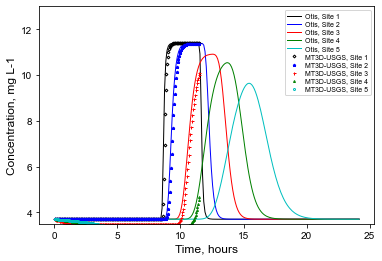

In [24]:
# set up figure
try:
    plt.close("all")
except:
    pass

set_plot_params()

fig = plt.figure(figsize=(6, 4), facecolor="w")
ax = fig.add_subplot(1, 1, 1)

ax.plot(ts1_Otis[:, 0], ts1_Otis[:, 1], "k-", linewidth=1.0)
ax.plot(ts2_Otis[:, 0], ts2_Otis[:, 1], "b-", linewidth=1.0)
ax.plot(ts3_Otis[:, 0], ts3_Otis[:, 1], "r-", linewidth=1.0)
ax.plot(ts4_Otis[:, 0], ts4_Otis[:, 1], "g-", linewidth=1.0)
ax.plot(ts5_Otis[:, 0], ts5_Otis[:, 1], "c-", linewidth=1.0)

ax.plot(
    (ts1_mt3d[:, 0]) / 3600,
    ts1_mt3d[:, 1],
    "kD",
    markersize=2.0,
    mfc="none",
    mec="k",
)
ax.plot(
    (ts2_mt3d[:, 0]) / 3600,
    ts2_mt3d[:, 1],
    "b*",
    markersize=3.0,
    mfc="none",
    mec="b",
)
ax.plot((ts3_mt3d[:, 0]) / 3600, ts3_mt3d[:, 1], "r+", markersize=3.0)
ax.plot(
    (ts4_mt3d[:, 0]) / 3600,
    ts4_mt3d[:, 1],
    "g^",
    markersize=2.0,
    mfc="none",
    mec="g",
)
ax.plot(
    (ts5_mt3d[:, 0]) / 3600,
    ts5_mt3d[:, 1],
    "co",
    markersize=2.0,
    mfc="none",
    mec="c",
)

# customize plot
ax.set_xlabel("Time, hours")
ax.set_ylabel("Concentration, mg L-1")
ax.set_ylim([3.5, 13])
ticksize = 10

# legend
leg = ax.legend(
    (
        "Otis, Site 1",
        "Otis, Site 2",
        "Otis, Site 3",
        "Otis, Site 4",
        "Otis, Site 5",
        "MT3D-USGS, Site 1",
        "MT3D-USGS, Site 2",
        "MT3D-USGS, Site 3",
        "MT3D-USGS, Site 4",
        "MT3D-USGS, Site 5",
    ),
    loc="upper right",
    labelspacing=0.25,
    columnspacing=1,
    handletextpad=0.5,
    handlelength=2.0,
    numpoints=1,
)
leg._drawFrame = False

plt.show()